# Приложение к диплому
Создание, обучение и анализ моделей

** Импортирование библиотек **

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
import pylab as plt
import mglearn

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
%matplotlib inline

In [2]:
def learning_curve_model(X, Y, model, cv, train_sizes):
    """Функция строит кривую обучения"""
    plt.figure(figsize=(10, 10))
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")


    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
                     
    plt.legend(loc="best")
    return plt

class NullColumnsCleaner(BaseEstimator, TransformerMixin):
    """Трансформер, который убирает колонки, содержащий большое кол-во пустых значений"""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        nulls = X.isnull().sum()
        nulls_keys = nulls[nulls > 50].keys()
        return X.drop(nulls_keys, axis=1).dropna()

## Чтение данных и первый взгляд

Первые пять строк данных

In [3]:
data = pd.read_excel('Data.xlsm')
data.head()

,"Stroke(AIS,TIA,AHS)",Sex01,StrokeAge,gFGB,gF2,gF5,gF7VII,gF13,gITGA,gITGB,...,gADD1 1378 G>T,gAGT T704C,gAGT C521T,gAGTR1 A 1166C,gAGTR2 G1675A,gCYP11B2 C344T,gGNB3 825C>T,gNOS3 T786C,gNOS3 G894T,DisNeuro01
0,AIS,1,1.0,0,0,0,0.0,1.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0
1,AIS,1,3.0,0,0,0,0.0,0.0,2.0,0.0,...,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0
2,AIS,0,5.0,0,0,0,0.0,1.0,1.0,2.0,...,1.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,0
3,AIS,1,0.0,0,0,0,0.0,0.0,2.0,1.0,...,0.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,1.0,0
4,AIS,1,13.0,0,0,0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
# Краткое описание данных. Количество признаков, столбцов, типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 25 columns):
Stroke(AIS,TIA,AHS)    154 non-null object
Sex01                  154 non-null int64
StrokeAge              151 non-null float64
gFGB                   154 non-null int64
gF2                    154 non-null int64
gF5                    154 non-null int64
gF7VII                 148 non-null float64
gF13                   148 non-null float64
gITGA                  151 non-null float64
gITGB                  152 non-null float64
gPAI-1                 153 non-null float64
gMTR:2756A>G           148 non-null float64
gMTRR:66A>G            148 non-null float64
gMTHFR677СT            152 non-null float64
gMTHFR:1298A>C         148 non-null float64
gADD1 1378 G>T         71 non-null float64
gAGT T704C             72 non-null float64
gAGT C521T             72 non-null float64
gAGTR1 A 1166C         72 non-null float64
gAGTR2 G1675A          72 non-null float64
gCYP11B2 C344T         72 non

In [5]:
# Стандартное отклонение, среднее, персентели
data.describe()

,Sex01,StrokeAge,gFGB,gF2,gF5,gF7VII,gF13,gITGA,gITGB,gPAI-1,...,gADD1 1378 G>T,gAGT T704C,gAGT C521T,gAGTR1 A 1166C,gAGTR2 G1675A,gCYP11B2 C344T,gGNB3 825C>T,gNOS3 T786C,gNOS3 G894T,DisNeuro01
count,154.000000,151.000000,154.000000,154.000000,154.000000,148.000000,148.000000,151.000000,152.000000,153.000000,...,71.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,81.000000,81.000000,154.000000
mean,0.655844,3.350993,0.577922,0.045455,0.064935,0.162162,0.594595,0.880795,0.388158,1.176471,...,0.577465,0.958333,0.333333,0.486111,1.097222,1.125000,0.541667,1.074074,0.567901,0.474026
std,0.476642,4.650733,0.634338,0.208979,0.272373,0.421433,0.668411,0.692119,0.540411,0.708201,...,0.710372,0.700855,0.530745,0.581234,0.921721,0.710832,0.626583,0.720725,0.650736,0.500954
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,4.500000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000
max,1.000000,17.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000


**Матрица корреляции**

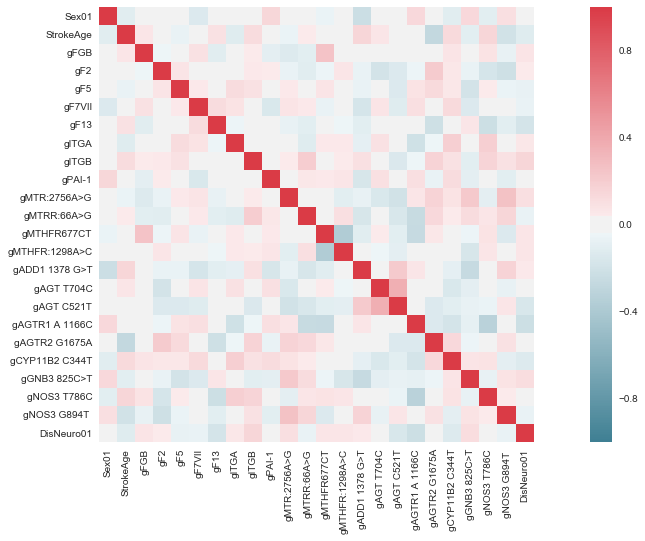

In [6]:
f, ax = plt.subplots(figsize=(20, 8))
corr = data.corr('spearman')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [7]:
corr["DisNeuro01"].sort_values(ascending=False)

DisNeuro01        1.000000
gITGB             0.148790
gGNB3 825C>T      0.113762
gMTR:2756A>G      0.107731
gFGB              0.072636
gMTHFR:1298A>C    0.068079
gMTHFR677СT       0.065608
gITGA             0.059500
gADD1 1378 G>T    0.049230
gF2               0.042567
gNOS3 T786C       0.037769
gAGTR2 G1675A     0.018982
gAGT T704C       -0.022679
Sex01            -0.023996
gPAI-1           -0.028985
gNOS3 G894T      -0.065599
gMTRR:66A>G      -0.066198
gF7VII           -0.070085
gF5              -0.071265
StrokeAge        -0.119893
gCYP11B2 C344T   -0.127977
gAGT C521T       -0.156649
gF13             -0.179711
gAGTR1 A 1166C   -0.223450
Name: DisNeuro01, dtype: float64

** Предварительная подготовка данных. Отчистка и скалирование **

In [8]:
# Убираем колонки
data = NullColumnsCleaner().fit_transform(data).reset_index(drop=True)
# Разбиение на предикаторы и зависимум переменную
X = data.drop(["DisNeuro01",  "Stroke(AIS,TIA,AHS)"], axis=1)
y = data["DisNeuro01"].copy()

# Разбиваем стратифицировано данные на train и test выборки
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    strat_train = data.loc[train_index]
    strat_test = data.loc[test_index]
X_train = strat_train.drop(["DisNeuro01",  "Stroke(AIS,TIA,AHS)"], axis=1)
y_train = strat_train["DisNeuro01"].copy()
X_test = strat_test.drop(["DisNeuro01",  "Stroke(AIS,TIA,AHS)"], axis=1)
y_test = strat_test["DisNeuro01"].copy()

# Добавляем полиминальные признаки и скалируем данные std=1 и median=0, и 
prep_pipe = Pipeline([('poly_feature', PolynomialFeatures(interaction_only=True)), 
                      ('std_scaler', StandardScaler()),]).fit(X_train)
X_train_prep = prep_pipe.transform(X_train)
X_test_prep = prep_pipe.transform(X_test)

**Логистическая регрессия**

Score:  0.739130434783 Test score:  0.620689655172 Best params:  {'C': 1, 'penalty': 'l1'}


<module 'pylab' from '/home/user/Desktop/machine_learning/myvenv/lib/python3.6/site-packages/pylab.py'>

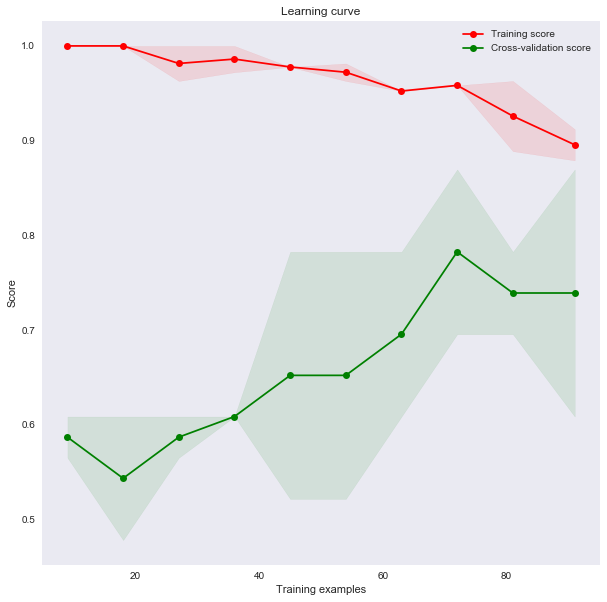

In [9]:
# Используем для подбора параметров кросс-валидацию
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
# Ищем наилучшие гиперпараметры для логистической регрессии(степень и уровнь регуляризации)
grid_search = GridSearchCV(LogisticRegression(), {"C": [0.001, 0.01, 0.1, 1, 3, 5, 10, 100], "penalty": ["l2", "l1"]}, cv=cv)
grid_search.fit(X_train_prep, y_train)
log_reg = grid_search.best_estimator_
print("Score: ", grid_search.best_score_,"Test score: ", log_reg.score(X_test_prep, y_test), "Best params: ", grid_search.best_params_)
learning_curve_model(X_train_prep, y_train, log_reg, cv, np.linspace(0.1, 1.0, 10))

(-5, 5)

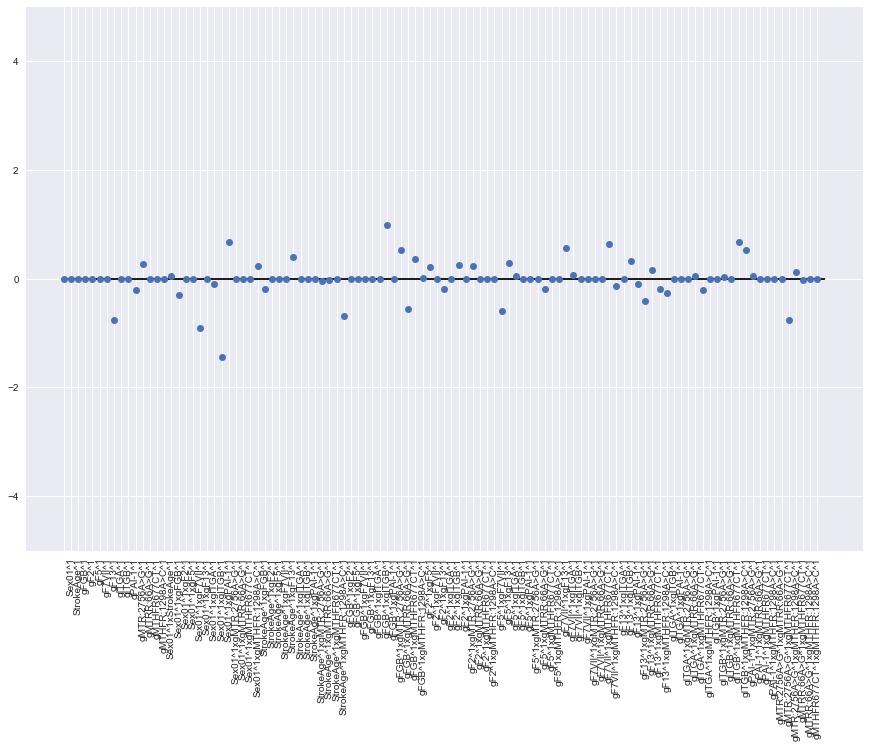

In [10]:
poly = PolynomialFeatures(interaction_only=True)
output_nparray = poly.fit_transform(X_train)
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) 
                                  for pair in tuple_ if pair[1]!=0]) for tuple_ in 
                        [zip(X.columns,p) for p in poly.powers_]]
output_df = pd.DataFrame(output_nparray, columns = target_feature_names)

plt.figure(figsize=(15,10))
plt.plot(log_reg.coef_.T, 'o', label='Коэффициенты логит. регресии')
plt.xticks(range(output_df.shape[1]), output_df.columns, rotation=90)
plt.hlines(0, 0, output_df.shape[1])
plt.ylim(-5, 5)

In [11]:
pred_y = y_train
pred_x = X_train_prep
pred_log_reg = log_reg.predict(pred_x)

confusion = confusion_matrix(pred_y, pred_log_reg)
print(classification_report(pred_y, pred_log_reg))
print("F1 score: ", f1_score(pred_y, pred_log_reg))

             precision    recall  f1-score   support

          0       0.89      0.92      0.90        60
          1       0.90      0.87      0.89        54

avg / total       0.90      0.89      0.89       114

F1 score:  0.88679245283


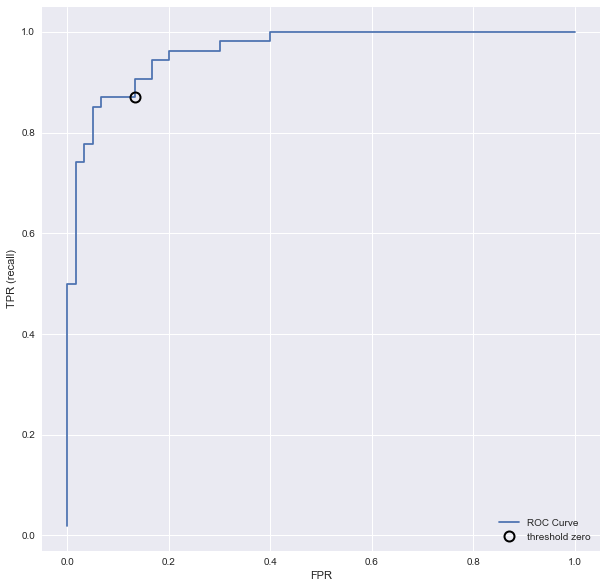

In [12]:
plt.figure(figsize=(10, 10))
fpr, tpr, thresholds = roc_curve(pred_y, log_reg.decision_function(pred_x))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

In [15]:
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[110, 110], feature_columns=feature_columns)
dnn_clf.fit(x=X_train, y=y_train.values, steps=5000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1111413198>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by movin

/home/user/Desktop/machine_learning/myvenv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp3__891a7/model.ckpt.
INFO:tensorflow:loss = 0.771107, step = 1
INFO:tensorflow:global_step/sec: 191.902
INFO:tensorflow:loss = 0.533631, step = 101 (0.518 sec)
INFO:tensorflow:global_step/sec: 194.995
INFO:tensorflow:loss = 0.378114, step = 201 (0.509 sec)
INFO:tensorflow:global_step/sec: 166.209
INFO:tensorflow:loss = 0.241967, step = 301 (0.600 sec)
INFO:tensorflow:global_step/sec: 194.761
INFO:tensorflow:loss = 0.147976, step = 401 (0.518 sec)
INFO:tensorflow:global_step/sec: 186.302
INFO:tensorflow:loss = 0.0782194, step = 501 (0.532 sec)
INFO:tensorflow:global_s

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x7f11263bec50>, 'hidden_units': [110, 110], 'feature_columns': (_RealValuedColumn(column_name='', dimension=14, default_value=None, dtype=tf.float64, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x7f1129e5dd08>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [17]:
dnn_clf.evaluate(X_test, y_test.values)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/home/user/Desktop/machine_learning/myvenv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-05-11-22:27:20
INFO:tensorflow:Restoring parameters from /tmp/tmp3__891a7/model.ckpt-5000
INFO:tensorflow:Finished evaluation at 2017-05-11-22:27:20
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.655172, accuracy/baseline_label_mean = 0.482759, accuracy/threshold_0.500000_mean = 0.655172, auc = 0.602381, global_step = 5000, labels/actual_label_mean = 0.482759, labels/prediction_mean = 0.503043, loss = 3.07454, precision/positive_threshold_0.500000_mean = 0.642857, recall/positive_threshold_0.500000_mean = 0.642857


{'accuracy': 0.65517241,
 'accuracy/baseline_label_mean': 0.48275861,
 'accuracy/threshold_0.500000_mean': 0.65517241,
 'auc': 0.60238093,
 'global_step': 5000,
 'labels/actual_label_mean': 0.48275861,
 'labels/prediction_mean': 0.503043,
 'loss': 3.0745437,
 'precision/positive_threshold_0.500000_mean': 0.64285713,
 'recall/positive_threshold_0.500000_mean': 0.64285713}

In [72]:
from keras.utils.np_utils import to_categorical
#y = to_categorical(y_train.values, num_classes=None)
model = Sequential()
model.add(Dense(110, input_dim=X_train_prep.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(110, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_prep, y_train.values.reshape(-1, 1), epochs=5000)

Epoch 1/5000
114/114 [==============================] - 0s - loss: 0.8543 - acc: 0.5088     
Epoch 2/5000
114/114 [==============================] - 0s - loss: 0.7509 - acc: 0.5614     
Epoch 3/5000
114/114 [==============================] - 0s - loss: 0.7603 - acc: 0.5000     
Epoch 4/5000
114/114 [==============================] - 0s - loss: 0.7144 - acc: 0.6228     
Epoch 5/5000
114/114 [==============================] - 0s - loss: 0.7379 - acc: 0.5614     
Epoch 6/5000
114/114 [==============================] - 0s - loss: 0.6825 - acc: 0.5702     
Epoch 7/5000
114/114 [==============================] - 0s - loss: 0.6585 - acc: 0.5965     
Epoch 8/5000
114/114 [==============================] - 0s - loss: 0.6451 - acc: 0.6316     
Epoch 9/5000
114/114 [==============================] - 0s - loss: 0.6605 - acc: 0.6228     
Epoch 10/5000
114/114 [==============================] - 0s - loss: 0.6236 - acc: 0.6930     
Epoch 11/5000
114/114 [==============================] - 0s - loss: 0

114/114 [==============================] - 0s - loss: 0.1782 - acc: 0.9298     
Epoch 88/5000
114/114 [==============================] - 0s - loss: 0.1116 - acc: 0.9737     
Epoch 89/5000
114/114 [==============================] - 0s - loss: 0.0961 - acc: 0.9912     
Epoch 90/5000
114/114 [==============================] - 0s - loss: 0.1144 - acc: 0.9737     
Epoch 91/5000
114/114 [==============================] - 0s - loss: 0.1508 - acc: 0.9298     
Epoch 92/5000
114/114 [==============================] - 0s - loss: 0.1438 - acc: 0.9386     
Epoch 93/5000
114/114 [==============================] - 0s - loss: 0.1240 - acc: 0.9561     
Epoch 94/5000
114/114 [==============================] - 0s - loss: 0.1093 - acc: 0.9912     
Epoch 95/5000
114/114 [==============================] - 0s - loss: 0.1204 - acc: 0.9649     
Epoch 96/5000
114/114 [==============================] - 0s - loss: 0.0891 - acc: 0.9825     
Epoch 97/5000
114/114 [==============================] - 0s - loss: 0.1067

114/114 [==============================] - 0s - loss: 0.0224 - acc: 0.9912     
Epoch 174/5000
114/114 [==============================] - ETA: 0s - loss: 0.0569 - acc: 1.000 - 0s - loss: 0.0292 - acc: 1.0000     
Epoch 175/5000
114/114 [==============================] - 0s - loss: 0.0692 - acc: 0.9825     
Epoch 176/5000
114/114 [==============================] - 0s - loss: 0.0219 - acc: 1.0000     
Epoch 177/5000
114/114 [==============================] - 0s - loss: 0.0199 - acc: 1.0000     
Epoch 178/5000
114/114 [==============================] - 0s - loss: 0.0225 - acc: 1.0000     
Epoch 179/5000
114/114 [==============================] - 0s - loss: 0.0365 - acc: 0.9912     
Epoch 180/5000
114/114 [==============================] - 0s - loss: 0.0268 - acc: 0.9912     
Epoch 181/5000
114/114 [==============================] - 0s - loss: 0.0239 - acc: 1.0000     
Epoch 182/5000
114/114 [==============================] - 0s - loss: 0.0544 - acc: 0.9825     
Epoch 183/5000
114/114 [===

114/114 [==============================] - 0s - loss: 0.0277 - acc: 0.9912     
Epoch 260/5000
114/114 [==============================] - 0s - loss: 0.0779 - acc: 0.9825     
Epoch 261/5000
114/114 [==============================] - 0s - loss: 0.0134 - acc: 1.0000     
Epoch 262/5000
114/114 [==============================] - 0s - loss: 0.0243 - acc: 0.9912     
Epoch 263/5000
114/114 [==============================] - 0s - loss: 0.0075 - acc: 1.0000     
Epoch 264/5000
114/114 [==============================] - 0s - loss: 0.0084 - acc: 1.0000     
Epoch 265/5000
114/114 [==============================] - 0s - loss: 0.0135 - acc: 1.0000     
Epoch 266/5000
114/114 [==============================] - 0s - loss: 0.0234 - acc: 0.9912     
Epoch 267/5000
114/114 [==============================] - 0s - loss: 0.0221 - acc: 1.0000     
Epoch 268/5000
114/114 [==============================] - 0s - loss: 0.0085 - acc: 1.0000     
Epoch 269/5000
114/114 [==============================] - 0s - lo

114/114 [==============================] - 0s - loss: 0.0073 - acc: 1.0000     
Epoch 345/5000
114/114 [==============================] - 0s - loss: 0.0075 - acc: 1.0000     
Epoch 346/5000
114/114 [==============================] - 0s - loss: 0.0060 - acc: 1.0000     
Epoch 347/5000
114/114 [==============================] - 0s - loss: 0.0030 - acc: 1.0000     
Epoch 348/5000
114/114 [==============================] - 0s - loss: 0.0046 - acc: 1.0000     
Epoch 349/5000
114/114 [==============================] - 0s - loss: 0.0069 - acc: 1.0000     
Epoch 350/5000
114/114 [==============================] - 0s - loss: 0.0023 - acc: 1.0000     
Epoch 351/5000
114/114 [==============================] - 0s - loss: 0.0030 - acc: 1.0000     
Epoch 352/5000
114/114 [==============================] - 0s - loss: 0.0106 - acc: 0.9912     
Epoch 353/5000
114/114 [==============================] - 0s - loss: 0.0023 - acc: 1.0000     
Epoch 354/5000
114/114 [==============================] - 0s - lo

114/114 [==============================] - 0s - loss: 0.0021 - acc: 1.0000     
Epoch 429/5000
114/114 [==============================] - 0s - loss: 0.0093 - acc: 1.0000     
Epoch 430/5000
114/114 [==============================] - 0s - loss: 0.0035 - acc: 1.0000         
Epoch 431/5000
114/114 [==============================] - 0s - loss: 0.0054 - acc: 1.0000     
Epoch 432/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000         
Epoch 433/5000
114/114 [==============================] - 0s - loss: 0.0046 - acc: 1.0000     
Epoch 434/5000
114/114 [==============================] - 0s - loss: 0.0025 - acc: 1.0000     
Epoch 435/5000
114/114 [==============================] - 0s - loss: 0.0064 - acc: 1.0000     
Epoch 436/5000
114/114 [==============================] - 0s - loss: 0.0048 - acc: 1.0000     
Epoch 437/5000
114/114 [==============================] - 0s - loss: 0.0019 - acc: 1.0000     
Epoch 438/5000
114/114 [==============================] -

114/114 [==============================] - 0s - loss: 0.0061 - acc: 1.0000     
Epoch 513/5000
114/114 [==============================] - 0s - loss: 0.0051 - acc: 1.0000     
Epoch 514/5000
114/114 [==============================] - 0s - loss: 0.0063 - acc: 1.0000     
Epoch 515/5000
114/114 [==============================] - 0s - loss: 0.0034 - acc: 1.0000     
Epoch 516/5000
114/114 [==============================] - 0s - loss: 0.0076 - acc: 1.0000     
Epoch 517/5000
114/114 [==============================] - 0s - loss: 0.0020 - acc: 1.0000     
Epoch 518/5000
114/114 [==============================] - 0s - loss: 0.0022 - acc: 1.0000         
Epoch 519/5000
114/114 [==============================] - 0s - loss: 0.0056 - acc: 1.0000     
Epoch 520/5000
114/114 [==============================] - 0s - loss: 0.0024 - acc: 1.0000     
Epoch 521/5000
114/114 [==============================] - 0s - loss: 0.0407 - acc: 0.9912         
Epoch 522/5000
114/114 [==============================] -

114/114 [==============================] - 0s - loss: 0.0159 - acc: 0.9912         
Epoch 598/5000
114/114 [==============================] - 0s - loss: 0.0106 - acc: 1.0000     
Epoch 599/5000
114/114 [==============================] - 0s - loss: 0.0020 - acc: 1.0000     
Epoch 600/5000
114/114 [==============================] - 0s - loss: 0.0032 - acc: 1.0000     
Epoch 601/5000
114/114 [==============================] - 0s - loss: 0.0015 - acc: 1.0000     
Epoch 602/5000
114/114 [==============================] - 0s - loss: 0.0105 - acc: 1.0000         
Epoch 603/5000
114/114 [==============================] - 0s - loss: 0.0027 - acc: 1.0000         
Epoch 604/5000
114/114 [==============================] - 0s - loss: 0.0072 - acc: 1.0000         
Epoch 605/5000
114/114 [==============================] - ETA: 0s - loss: 0.0017 - acc: 1.000 - 0s - loss: 0.0021 - acc: 1.0000     
Epoch 606/5000
114/114 [==============================] - 0s - loss: 0.0055 - acc: 1.0000     
Epoch 607/5

114/114 [==============================] - 0s - loss: 0.0100 - acc: 0.9912     
Epoch 682/5000
114/114 [==============================] - 0s - loss: 0.0033 - acc: 1.0000     
Epoch 683/5000
114/114 [==============================] - 0s - loss: 0.0098 - acc: 1.0000         
Epoch 684/5000
114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000     
Epoch 685/5000
114/114 [==============================] - 0s - loss: 0.0069 - acc: 1.0000         
Epoch 686/5000
114/114 [==============================] - 0s - loss: 5.1810e-04 - acc: 1.0000     
Epoch 687/5000
114/114 [==============================] - 0s - loss: 0.0238 - acc: 0.9912     
Epoch 688/5000
114/114 [==============================] - 0s - loss: 0.0017 - acc: 1.0000     
Epoch 689/5000
114/114 [==============================] - 0s - loss: 0.1475 - acc: 0.9912     
Epoch 690/5000
114/114 [==============================] - 0s - loss: 0.0587 - acc: 0.9825     
Epoch 691/5000
114/114 [=============================

114/114 [==============================] - 0s - loss: 0.0015 - acc: 1.0000         
Epoch 767/5000
114/114 [==============================] - 0s - loss: 0.0033 - acc: 1.0000         
Epoch 768/5000
114/114 [==============================] - 0s - loss: 0.0600 - acc: 0.9912         
Epoch 769/5000
114/114 [==============================] - 0s - loss: 5.2358e-04 - acc: 1.0000     
Epoch 770/5000
114/114 [==============================] - 0s - loss: 0.0059 - acc: 1.0000     
Epoch 771/5000
114/114 [==============================] - 0s - loss: 0.0079 - acc: 0.9912         
Epoch 772/5000
114/114 [==============================] - 0s - loss: 0.0035 - acc: 1.0000         
Epoch 773/5000
114/114 [==============================] - 0s - loss: 0.0025 - acc: 1.0000     
Epoch 774/5000
114/114 [==============================] - 0s - loss: 0.0195 - acc: 0.9912         
Epoch 775/5000
114/114 [==============================] - 0s - loss: 0.0054 - acc: 1.0000         
Epoch 776/5000
114/114 [=========

114/114 [==============================] - 0s - loss: 8.4763e-04 - acc: 1.0000     
Epoch 851/5000
114/114 [==============================] - 0s - loss: 5.9827e-04 - acc: 1.0000     
Epoch 852/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 853/5000
114/114 [==============================] - 0s - loss: 0.0037 - acc: 1.0000         
Epoch 854/5000
114/114 [==============================] - 0s - loss: 8.8892e-04 - acc: 1.0000 
Epoch 855/5000
114/114 [==============================] - 0s - loss: 0.0015 - acc: 1.0000         
Epoch 856/5000
114/114 [==============================] - 0s - loss: 4.6392e-04 - acc: 1.0000     
Epoch 857/5000
114/114 [==============================] - 0s - loss: 3.7440e-04 - acc: 1.0000     
Epoch 858/5000
114/114 [==============================] - 0s - loss: 8.4092e-04 - acc: 1.0000     
Epoch 859/5000
114/114 [==============================] - 0s - loss: 0.0021 - acc: 1.0000     
Epoch 860/5000
114/114 [=============

114/114 [==============================] - 0s - loss: 0.0028 - acc: 1.0000         
Epoch 934/5000
114/114 [==============================] - 0s - loss: 4.6741e-04 - acc: 1.0000     
Epoch 935/5000
114/114 [==============================] - 0s - loss: 2.2200e-04 - acc: 1.0000     
Epoch 936/5000
114/114 [==============================] - 0s - loss: 9.6942e-04 - acc: 1.0000 
Epoch 937/5000
114/114 [==============================] - 0s - loss: 0.0020 - acc: 1.0000     
Epoch 938/5000
114/114 [==============================] - 0s - loss: 0.0781 - acc: 0.9912     
Epoch 939/5000
114/114 [==============================] - 0s - loss: 0.0033 - acc: 1.0000     
Epoch 940/5000
114/114 [==============================] - 0s - loss: 1.6430e-04 - acc: 1.0000     
Epoch 941/5000
114/114 [==============================] - 0s - loss: 0.0030 - acc: 1.0000         
Epoch 942/5000
114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000         
Epoch 943/5000
114/114 [=================

114/114 [==============================] - 0s - loss: 0.0581 - acc: 0.9912         
Epoch 1016/5000
114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000         
Epoch 1017/5000
114/114 [==============================] - 0s - loss: 3.1926e-04 - acc: 1.0000     
Epoch 1018/5000
114/114 [==============================] - 0s - loss: 6.8834e-04 - acc: 1.0000     
Epoch 1019/5000
114/114 [==============================] - 0s - loss: 4.2339e-04 - acc: 1.0000     
Epoch 1020/5000
114/114 [==============================] - 0s - loss: 0.0015 - acc: 1.0000         
Epoch 1021/5000
114/114 [==============================] - 0s - loss: 3.1057e-04 - acc: 1.0000     
Epoch 1022/5000
114/114 [==============================] - 0s - loss: 7.6181e-04 - acc: 1.0000     
Epoch 1023/5000
114/114 [==============================] - 0s - loss: 0.0049 - acc: 1.0000     
Epoch 1024/5000
114/114 [==============================] - 0s - loss: 7.0943e-04 - acc: 1.0000     
Epoch 1025/5000
114/

114/114 [==============================] - 0s - loss: 3.3114e-04 - acc: 1.0000     
Epoch 1098/5000
114/114 [==============================] - 0s - loss: 0.0013 - acc: 1.0000         
Epoch 1099/5000
114/114 [==============================] - 0s - loss: 4.5772e-04 - acc: 1.0000     
Epoch 1100/5000
114/114 [==============================] - 0s - loss: 0.0064 - acc: 1.0000     
Epoch 1101/5000
114/114 [==============================] - 0s - loss: 2.0543e-04 - acc: 1.0000     
Epoch 1102/5000
114/114 [==============================] - 0s - loss: 2.0585e-04 - acc: 1.0000     
Epoch 1103/5000
114/114 [==============================] - 0s - loss: 1.9006e-04 - acc: 1.0000     
Epoch 1104/5000
114/114 [==============================] - 0s - loss: 0.0034 - acc: 1.0000         
Epoch 1105/5000
114/114 [==============================] - 0s - loss: 0.0014 - acc: 1.0000         
Epoch 1106/5000
114/114 [==============================] - 0s - loss: 6.5177e-04 - acc: 1.0000     
Epoch 1107/5000
114/

114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 1181/5000
114/114 [==============================] - 0s - loss: 0.0041 - acc: 1.0000     
Epoch 1182/5000
114/114 [==============================] - 0s - loss: 9.7463e-05 - acc: 1.0000     
Epoch 1183/5000
114/114 [==============================] - 0s - loss: 2.9007e-04 - acc: 1.0000     
Epoch 1184/5000
114/114 [==============================] - 0s - loss: 0.0105 - acc: 0.9912     
Epoch 1185/5000
114/114 [==============================] - 0s - loss: 0.0024 - acc: 1.0000     
Epoch 1186/5000
114/114 [==============================] - 0s - loss: 9.8659e-04 - acc: 1.0000     
Epoch 1187/5000
114/114 [==============================] - 0s - loss: 3.6954e-04 - acc: 1.0000     
Epoch 1188/5000
114/114 [==============================] - 0s - loss: 9.0056e-04 - acc: 1.0000 
Epoch 1189/5000
114/114 [==============================] - 0s - loss: 0.0024 - acc: 1.0000         
Epoch 1190/5000
114/114 [===========

114/114 [==============================] - 0s - loss: 2.7094e-04 - acc: 1.0000     
Epoch 1263/5000
114/114 [==============================] - 0s - loss: 4.8346e-04 - acc: 1.0000     
Epoch 1264/5000
114/114 [==============================] - 0s - loss: 0.0083 - acc: 0.9912         
Epoch 1265/5000
114/114 [==============================] - 0s - loss: 1.7758e-04 - acc: 1.0000     
Epoch 1266/5000
114/114 [==============================] - 0s - loss: 0.0017 - acc: 1.0000     
Epoch 1267/5000
114/114 [==============================] - 0s - loss: 1.1391e-04 - acc: 1.0000     
Epoch 1268/5000
114/114 [==============================] - 0s - loss: 0.0095 - acc: 0.9912     
Epoch 1269/5000
114/114 [==============================] - ETA: 0s - loss: 7.8412e-05 - acc: 1.000 - 0s - loss: 1.0859e-04 - acc: 1.0000     
Epoch 1270/5000
114/114 [==============================] - 0s - loss: 0.0109 - acc: 0.9912     
Epoch 1271/5000
114/114 [==============================] - 0s - loss: 0.0041 - acc: 1.

114/114 [==============================] - 0s - loss: 1.1095e-04 - acc: 1.0000     
Epoch 1345/5000
114/114 [==============================] - 0s - loss: 4.0983e-04 - acc: 1.0000     
Epoch 1346/5000
114/114 [==============================] - 0s - loss: 9.4774e-05 - acc: 1.0000     
Epoch 1347/5000
114/114 [==============================] - 0s - loss: 6.5922e-05 - acc: 1.0000     
Epoch 1348/5000
114/114 [==============================] - 0s - loss: 2.6930e-04 - acc: 1.0000     
Epoch 1349/5000
114/114 [==============================] - 0s - loss: 2.0239e-04 - acc: 1.0000     
Epoch 1350/5000
114/114 [==============================] - 0s - loss: 1.5268e-04 - acc: 1.0000     
Epoch 1351/5000
114/114 [==============================] - 0s - loss: 3.0497e-04 - acc: 1.0000     
Epoch 1352/5000
114/114 [==============================] - 0s - loss: 7.2549e-05 - acc: 1.0000     
Epoch 1353/5000
114/114 [==============================] - 0s - loss: 2.6388e-04 - acc: 1.0000     
Epoch 1354/5000


114/114 [==============================] - 0s - loss: 2.7417e-04 - acc: 1.0000     
Epoch 1427/5000
114/114 [==============================] - 0s - loss: 9.9184e-04 - acc: 1.0000     
Epoch 1428/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000         
Epoch 1429/5000
114/114 [==============================] - 0s - loss: 0.0084 - acc: 0.9912     
Epoch 1430/5000
114/114 [==============================] - 0s - loss: 0.0048 - acc: 1.0000         
Epoch 1431/5000
114/114 [==============================] - 0s - loss: 0.0181 - acc: 0.9912     
Epoch 1432/5000
114/114 [==============================] - 0s - loss: 0.0047 - acc: 1.0000         
Epoch 1433/5000
114/114 [==============================] - 0s - loss: 0.0211 - acc: 0.9912         
Epoch 1434/5000
114/114 [==============================] - 0s - loss: 0.0031 - acc: 1.0000     
Epoch 1435/5000
114/114 [==============================] - 0s - loss: 5.6274e-04 - acc: 1.0000     
Epoch 1436/5000
114/114 [===

114/114 [==============================] - 0s - loss: 1.4497e-04 - acc: 1.0000     
Epoch 1509/5000
114/114 [==============================] - 0s - loss: 0.0035 - acc: 1.0000         
Epoch 1510/5000
114/114 [==============================] - 0s - loss: 4.0878e-04 - acc: 1.0000     
Epoch 1511/5000
114/114 [==============================] - 0s - loss: 4.0180e-04 - acc: 1.0000 
Epoch 1512/5000
114/114 [==============================] - 0s - loss: 6.3473e-04 - acc: 1.0000     
Epoch 1513/5000
114/114 [==============================] - 0s - loss: 1.1614e-04 - acc: 1.0000     
Epoch 1514/5000
114/114 [==============================] - 0s - loss: 3.6329e-04 - acc: 1.0000     
Epoch 1515/5000
114/114 [==============================] - 0s - loss: 0.0013 - acc: 1.0000         
Epoch 1516/5000
114/114 [==============================] - 0s - loss: 5.9885e-05 - acc: 1.0000     
Epoch 1517/5000
114/114 [==============================] - 0s - loss: 3.2453e-04 - acc: 1.0000     
Epoch 1518/5000
114/

114/114 [==============================] - 0s - loss: 8.9859e-04 - acc: 1.0000     
Epoch 1591/5000
114/114 [==============================] - 0s - loss: 9.9137e-05 - acc: 1.0000     
Epoch 1592/5000
114/114 [==============================] - 0s - loss: 8.4415e-04 - acc: 1.0000     
Epoch 1593/5000
114/114 [==============================] - 0s - loss: 2.3135e-04 - acc: 1.0000     
Epoch 1594/5000
114/114 [==============================] - 0s - loss: 3.9095e-04 - acc: 1.0000     
Epoch 1595/5000
114/114 [==============================] - 0s - loss: 0.0104 - acc: 0.9912     
Epoch 1596/5000
114/114 [==============================] - 0s - loss: 9.1233e-04 - acc: 1.0000 
Epoch 1597/5000
114/114 [==============================] - 0s - loss: 0.0265 - acc: 0.9912         
Epoch 1598/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000         
Epoch 1599/5000
114/114 [==============================] - 0s - loss: 8.2646e-04 - acc: 1.0000     
Epoch 1600/5000
114/114 

114/114 [==============================] - 0s - loss: 5.3031e-04 - acc: 1.0000     
Epoch 1673/5000
114/114 [==============================] - 0s - loss: 0.0167 - acc: 0.9912         
Epoch 1674/5000
114/114 [==============================] - 0s - loss: 0.0022 - acc: 1.0000     
Epoch 1675/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 1676/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000         
Epoch 1677/5000
114/114 [==============================] - 0s - loss: 0.0023 - acc: 1.0000         
Epoch 1678/5000
114/114 [==============================] - 0s - loss: 0.0022 - acc: 1.0000         
Epoch 1679/5000
114/114 [==============================] - 0s - loss: 0.1152 - acc: 0.9912         
Epoch 1680/5000
114/114 [==============================] - 0s - loss: 0.0080 - acc: 0.9912     
Epoch 1681/5000
114/114 [==============================] - 0s - loss: 0.0049 - acc: 1.0000         
Epoch 1682/5000
114/114 [===

114/114 [==============================] - 0s - loss: 0.0017 - acc: 1.0000     
Epoch 1756/5000
114/114 [==============================] - 0s - loss: 0.0017 - acc: 1.0000     
Epoch 1757/5000
114/114 [==============================] - 0s - loss: 0.0026 - acc: 1.0000         
Epoch 1758/5000
114/114 [==============================] - 0s - loss: 0.0015 - acc: 1.0000     
Epoch 1759/5000
114/114 [==============================] - 0s - loss: 0.0307 - acc: 0.9912         
Epoch 1760/5000
114/114 [==============================] - 0s - loss: 2.8629e-04 - acc: 1.0000     
Epoch 1761/5000
114/114 [==============================] - 0s - loss: 3.4818e-04 - acc: 1.0000     
Epoch 1762/5000
114/114 [==============================] - 0s - loss: 1.0518e-04 - acc: 1.0000     
Epoch 1763/5000
114/114 [==============================] - 0s - loss: 0.0035 - acc: 1.0000     
Epoch 1764/5000
114/114 [==============================] - 0s - loss: 0.0010 - acc: 1.0000         
Epoch 1765/5000
114/114 [=======

114/114 [==============================] - 0s - loss: 0.0022 - acc: 1.0000         
Epoch 1838/5000
114/114 [==============================] - 0s - loss: 2.0145e-04 - acc: 1.0000     
Epoch 1839/5000
114/114 [==============================] - 0s - loss: 3.8585e-04 - acc: 1.0000     
Epoch 1840/5000
114/114 [==============================] - 0s - loss: 2.4921e-04 - acc: 1.0000     
Epoch 1841/5000
114/114 [==============================] - 0s - loss: 0.0021 - acc: 1.0000         
Epoch 1842/5000
114/114 [==============================] - 0s - loss: 7.6234e-05 - acc: 1.0000     
Epoch 1843/5000
114/114 [==============================] - 0s - loss: 0.0014 - acc: 1.0000         
Epoch 1844/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000         
Epoch 1845/5000
114/114 [==============================] - 0s - loss: 5.2094e-04 - acc: 1.0000 
Epoch 1846/5000
114/114 [==============================] - 0s - loss: 0.0032 - acc: 1.0000         
Epoch 1847/5000
114/

114/114 [==============================] - 0s - loss: 5.7210e-04 - acc: 1.0000 
Epoch 1919/5000
114/114 [==============================] - 0s - loss: 7.3285e-04 - acc: 1.0000 
Epoch 1920/5000
114/114 [==============================] - 0s - loss: 0.0039 - acc: 1.0000     
Epoch 1921/5000
114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000     
Epoch 1922/5000
114/114 [==============================] - 0s - loss: 0.0178 - acc: 0.9912     
Epoch 1923/5000
114/114 [==============================] - 0s - loss: 6.4861e-04 - acc: 1.0000     
Epoch 1924/5000
114/114 [==============================] - 0s - loss: 0.0013 - acc: 1.0000     
Epoch 1925/5000
114/114 [==============================] - 0s - loss: 1.3161e-04 - acc: 1.0000     
Epoch 1926/5000
114/114 [==============================] - 0s - loss: 3.6149e-04 - acc: 1.0000     
Epoch 1927/5000
114/114 [==============================] - 0s - loss: 5.2976e-04 - acc: 1.0000     
Epoch 1928/5000
114/114 [===============

114/114 [==============================] - 0s - loss: 0.0159 - acc: 0.9912         
Epoch 2001/5000
114/114 [==============================] - 0s - loss: 2.6663e-04 - acc: 1.0000     
Epoch 2002/5000
114/114 [==============================] - 0s - loss: 4.9022e-04 - acc: 1.0000     
Epoch 2003/5000
114/114 [==============================] - 0s - loss: 9.5060e-05 - acc: 1.0000     
Epoch 2004/5000
114/114 [==============================] - 0s - loss: 1.8220e-04 - acc: 1.0000     
Epoch 2005/5000
114/114 [==============================] - 0s - loss: 4.6162e-04 - acc: 1.0000     
Epoch 2006/5000
114/114 [==============================] - 0s - loss: 2.2292e-04 - acc: 1.0000     
Epoch 2007/5000
114/114 [==============================] - 0s - loss: 1.1109e-04 - acc: 1.0000     
Epoch 2008/5000
114/114 [==============================] - 0s - loss: 2.7955e-04 - acc: 1.0000     
Epoch 2009/5000
114/114 [==============================] - 0s - loss: 9.5056e-05 - acc: 1.0000     
Epoch 2010/5000


114/114 [==============================] - 0s - loss: 8.6571e-04 - acc: 1.0000 
Epoch 2082/5000
114/114 [==============================] - 0s - loss: 0.0036 - acc: 1.0000         
Epoch 2083/5000
114/114 [==============================] - 0s - loss: 0.0130 - acc: 0.9912         
Epoch 2084/5000
114/114 [==============================] - 0s - loss: 1.5863e-04 - acc: 1.0000     
Epoch 2085/5000
114/114 [==============================] - 0s - loss: 1.8502e-04 - acc: 1.0000     
Epoch 2086/5000
114/114 [==============================] - 0s - loss: 7.7830e-04 - acc: 1.0000 
Epoch 2087/5000
114/114 [==============================] - 0s - loss: 3.8369e-04 - acc: 1.0000     
Epoch 2088/5000
114/114 [==============================] - 0s - loss: 0.0371 - acc: 0.9912         
Epoch 2089/5000
114/114 [==============================] - 0s - loss: 0.0015 - acc: 1.0000         
Epoch 2090/5000
114/114 [==============================] - 0s - loss: 1.3042e-04 - acc: 1.0000     
Epoch 2091/5000
114/114 

114/114 [==============================] - 0s - loss: 0.0078 - acc: 0.9912     
Epoch 2164/5000
114/114 [==============================] - 0s - loss: 0.0389 - acc: 0.9912         
Epoch 2165/5000
114/114 [==============================] - 0s - loss: 0.0032 - acc: 1.0000         
Epoch 2166/5000
114/114 [==============================] - 0s - loss: 3.2140e-04 - acc: 1.0000     
Epoch 2167/5000
114/114 [==============================] - 0s - loss: 2.3016e-04 - acc: 1.0000     
Epoch 2168/5000
114/114 [==============================] - 0s - loss: 9.3988e-04 - acc: 1.0000     
Epoch 2169/5000
114/114 [==============================] - 0s - loss: 5.5248e-04 - acc: 1.0000     
Epoch 2170/5000
114/114 [==============================] - 0s - loss: 0.1325 - acc: 0.9912         
Epoch 2171/5000
114/114 [==============================] - 0s - loss: 0.0159 - acc: 0.9912         
Epoch 2172/5000
114/114 [==============================] - 0s - loss: 0.0083 - acc: 0.9912         
Epoch 2173/5000
114/

114/114 [==============================] - 0s - loss: 5.9750e-04 - acc: 1.0000 
Epoch 2245/5000
114/114 [==============================] - 0s - loss: 0.0017 - acc: 1.0000     
Epoch 2246/5000
114/114 [==============================] - 0s - loss: 0.0061 - acc: 1.0000         
Epoch 2247/5000
114/114 [==============================] - 0s - loss: 5.7966e-05 - acc: 1.0000     
Epoch 2248/5000
114/114 [==============================] - 0s - loss: 2.6558e-04 - acc: 1.0000     
Epoch 2249/5000
114/114 [==============================] - 0s - loss: 9.3163e-05 - acc: 1.0000     
Epoch 2250/5000
114/114 [==============================] - 0s - loss: 0.0034 - acc: 1.0000         
Epoch 2251/5000
114/114 [==============================] - 0s - loss: 0.0042 - acc: 1.0000     
Epoch 2252/5000
114/114 [==============================] - 0s - loss: 2.1558e-05 - acc: 1.0000     
Epoch 2253/5000
114/114 [==============================] - 0s - loss: 0.0321 - acc: 0.9912     
Epoch 2254/5000
114/114 [=======

114/114 [==============================] - 0s - loss: 1.0928e-04 - acc: 1.0000     
Epoch 2325/5000
114/114 [==============================] - 0s - loss: 0.0049 - acc: 1.0000     
Epoch 2326/5000
114/114 [==============================] - 0s - loss: 5.9883e-05 - acc: 1.0000     
Epoch 2327/5000
114/114 [==============================] - 0s - loss: 9.1549e-05 - acc: 1.0000     
Epoch 2328/5000
114/114 [==============================] - 0s - loss: 0.0281 - acc: 0.9912     
Epoch 2329/5000
114/114 [==============================] - 0s - loss: 0.0021 - acc: 1.0000     
Epoch 2330/5000
114/114 [==============================] - 0s - loss: 6.5281e-04 - acc: 1.0000     
Epoch 2331/5000
114/114 [==============================] - 0s - loss: 3.5393e-04 - acc: 1.0000     
Epoch 2332/5000
114/114 [==============================] - 0s - loss: 0.0027 - acc: 1.0000         
Epoch 2333/5000
114/114 [==============================] - 0s - loss: 1.5045e-04 - acc: 1.0000     
Epoch 2334/5000
114/114 [===

114/114 [==============================] - 0s - loss: 1.8037e-04 - acc: 1.0000     
Epoch 2407/5000
114/114 [==============================] - 0s - loss: 0.0070 - acc: 0.9912     
Epoch 2408/5000
114/114 [==============================] - 0s - loss: 0.0408 - acc: 0.9912     
Epoch 2409/5000
114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000         
Epoch 2410/5000
114/114 [==============================] - 0s - loss: 0.0117 - acc: 0.9912     
Epoch 2411/5000
114/114 [==============================] - 0s - loss: 0.0408 - acc: 0.9912         
Epoch 2412/5000
114/114 [==============================] - 0s - loss: 2.0004e-04 - acc: 1.0000     
Epoch 2413/5000
114/114 [==============================] - 0s - loss: 5.4456e-05 - acc: 1.0000     
Epoch 2414/5000
114/114 [==============================] - 0s - loss: 5.6005e-04 - acc: 1.0000 
Epoch 2415/5000
114/114 [==============================] - 0s - loss: 6.3353e-05 - acc: 1.0000     
Epoch 2416/5000
114/114 [=======

114/114 [==============================] - 0s - loss: 0.0017 - acc: 1.0000         
Epoch 2489/5000
114/114 [==============================] - 0s - loss: 0.0161 - acc: 0.9912     
Epoch 2490/5000
114/114 [==============================] - 0s - loss: 6.1304e-04 - acc: 1.0000     
Epoch 2491/5000
114/114 [==============================] - 0s - loss: 7.4785e-04 - acc: 1.0000 
Epoch 2492/5000
114/114 [==============================] - 0s - loss: 1.0716e-04 - acc: 1.0000     
Epoch 2493/5000
114/114 [==============================] - 0s - loss: 0.0010 - acc: 1.0000         
Epoch 2494/5000
114/114 [==============================] - 0s - loss: 1.9543e-04 - acc: 1.0000     
Epoch 2495/5000
114/114 [==============================] - 0s - loss: 1.5060e-04 - acc: 1.0000     
Epoch 2496/5000
114/114 [==============================] - 0s - loss: 2.0179e-04 - acc: 1.0000     
Epoch 2497/5000
114/114 [==============================] - 0s - loss: 0.0288 - acc: 0.9912     
Epoch 2498/5000
114/114 [===

114/114 [==============================] - 0s - loss: 0.0010 - acc: 1.0000         
Epoch 2570/5000
114/114 [==============================] - 0s - loss: 2.6661e-05 - acc: 1.0000     
Epoch 2571/5000
114/114 [==============================] - 0s - loss: 1.7379e-04 - acc: 1.0000     
Epoch 2572/5000
114/114 [==============================] - 0s - loss: 3.0475e-04 - acc: 1.0000     
Epoch 2573/5000
114/114 [==============================] - 0s - loss: 4.0568e-05 - acc: 1.0000     
Epoch 2574/5000
114/114 [==============================] - 0s - loss: 3.7760e-04 - acc: 1.0000 
Epoch 2575/5000
114/114 [==============================] - 0s - loss: 8.4805e-05 - acc: 1.0000     
Epoch 2576/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 2577/5000
114/114 [==============================] - 0s - loss: 3.6859e-04 - acc: 1.0000     
Epoch 2578/5000
114/114 [==============================] - 0s - loss: 1.5470e-04 - acc: 1.0000     
Epoch 2579/5000
114/114 

114/114 [==============================] - 0s - loss: 8.7351e-05 - acc: 1.0000     
Epoch 2650/5000
114/114 [==============================] - 0s - loss: 0.0055 - acc: 1.0000         
Epoch 2651/5000
114/114 [==============================] - 0s - loss: 0.0032 - acc: 1.0000     
Epoch 2652/5000
114/114 [==============================] - 0s - loss: 4.4307e-05 - acc: 1.0000     
Epoch 2653/5000
114/114 [==============================] - 0s - loss: 3.4936e-04 - acc: 1.0000     
Epoch 2654/5000
114/114 [==============================] - 0s - loss: 6.9534e-05 - acc: 1.0000     
Epoch 2655/5000
114/114 [==============================] - 0s - loss: 1.8027e-04 - acc: 1.0000     
Epoch 2656/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000         
Epoch 2657/5000
114/114 [==============================] - 0s - loss: 4.4921e-04 - acc: 1.0000     
Epoch 2658/5000
114/114 [==============================] - 0s - loss: 6.0930e-05 - acc: 1.0000     
Epoch 2659/5000
114/

114/114 [==============================] - 0s - loss: 8.9539e-05 - acc: 1.0000     
Epoch 2732/5000
114/114 [==============================] - 0s - loss: 7.2173e-04 - acc: 1.0000     
Epoch 2733/5000
114/114 [==============================] - 0s - loss: 4.6727e-05 - acc: 1.0000     
Epoch 2734/5000
114/114 [==============================] - 0s - loss: 2.7800e-04 - acc: 1.0000     
Epoch 2735/5000
114/114 [==============================] - 0s - loss: 2.9329e-04 - acc: 1.0000     
Epoch 2736/5000
114/114 [==============================] - 0s - loss: 4.9681e-04 - acc: 1.0000     
Epoch 2737/5000
114/114 [==============================] - 0s - loss: 1.5800e-04 - acc: 1.0000     
Epoch 2738/5000
114/114 [==============================] - 0s - loss: 9.5813e-06 - acc: 1.0000     
Epoch 2739/5000
114/114 [==============================] - 0s - loss: 0.0057 - acc: 1.0000     
Epoch 2740/5000
114/114 [==============================] - 0s - loss: 8.6657e-05 - acc: 1.0000     
Epoch 2741/5000
114/

114/114 [==============================] - 0s - loss: 2.0482e-04 - acc: 1.0000     
Epoch 2814/5000
114/114 [==============================] - ETA: 0s - loss: 1.1131e-05 - acc: 1.000 - 0s - loss: 3.6741e-05 - acc: 1.0000     
Epoch 2815/5000
114/114 [==============================] - 0s - loss: 7.2054e-05 - acc: 1.0000     
Epoch 2816/5000
114/114 [==============================] - 0s - loss: 0.0013 - acc: 1.0000         
Epoch 2817/5000
114/114 [==============================] - 0s - loss: 4.0521e-04 - acc: 1.0000     
Epoch 2818/5000
114/114 [==============================] - 0s - loss: 4.6161e-05 - acc: 1.0000     
Epoch 2819/5000
114/114 [==============================] - 0s - loss: 0.0015 - acc: 1.0000         
Epoch 2820/5000
114/114 [==============================] - 0s - loss: 3.2980e-04 - acc: 1.0000     
Epoch 2821/5000
114/114 [==============================] - 0s - loss: 1.4547e-04 - acc: 1.0000     
Epoch 2822/5000
114/114 [==============================] - 0s - loss: 1.24

114/114 [==============================] - 0s - loss: 5.1738e-05 - acc: 1.0000     
Epoch 2894/5000
114/114 [==============================] - 0s - loss: 9.2219e-05 - acc: 1.0000     
Epoch 2895/5000
114/114 [==============================] - 0s - loss: 8.3089e-05 - acc: 1.0000     
Epoch 2896/5000
114/114 [==============================] - 0s - loss: 9.2749e-05 - acc: 1.0000     
Epoch 2897/5000
114/114 [==============================] - 0s - loss: 6.1794e-05 - acc: 1.0000     
Epoch 2898/5000
114/114 [==============================] - 0s - loss: 4.6676e-05 - acc: 1.0000     
Epoch 2899/5000
114/114 [==============================] - 0s - loss: 1.6058e-05 - acc: 1.0000     
Epoch 2900/5000
114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000     
Epoch 2901/5000
114/114 [==============================] - 0s - loss: 4.3752e-04 - acc: 1.0000     
Epoch 2902/5000
114/114 [==============================] - 0s - loss: 3.2314e-04 - acc: 1.0000     
Epoch 2903/5000
114/

114/114 [==============================] - 0s - loss: 9.7092e-06 - acc: 1.0000     
Epoch 2975/5000
114/114 [==============================] - 0s - loss: 4.9729e-04 - acc: 1.0000 
Epoch 2976/5000
114/114 [==============================] - 0s - loss: 1.9892e-04 - acc: 1.0000     
Epoch 2977/5000
114/114 [==============================] - 0s - loss: 2.9745e-05 - acc: 1.0000     
Epoch 2978/5000
114/114 [==============================] - 0s - loss: 1.4590e-04 - acc: 1.0000     
Epoch 2979/5000
114/114 [==============================] - 0s - loss: 1.2906e-04 - acc: 1.0000     
Epoch 2980/5000
114/114 [==============================] - 0s - loss: 7.1869e-05 - acc: 1.0000     
Epoch 2981/5000
114/114 [==============================] - 0s - loss: 1.6989e-04 - acc: 1.0000     
Epoch 2982/5000
114/114 [==============================] - 0s - loss: 9.5781e-05 - acc: 1.0000     
Epoch 2983/5000
114/114 [==============================] - 0s - loss: 5.0715e-05 - acc: 1.0000     
Epoch 2984/5000
114/

114/114 [==============================] - 0s - loss: 1.1854e-05 - acc: 1.0000     
Epoch 3056/5000
114/114 [==============================] - 0s - loss: 9.2430e-05 - acc: 1.0000     
Epoch 3057/5000
114/114 [==============================] - 0s - loss: 3.8792e-05 - acc: 1.0000     
Epoch 3058/5000
114/114 [==============================] - 0s - loss: 6.6979e-06 - acc: 1.0000     
Epoch 3059/5000
114/114 [==============================] - 0s - loss: 2.6730e-05 - acc: 1.0000     
Epoch 3060/5000
114/114 [==============================] - 0s - loss: 5.3374e-04 - acc: 1.0000     
Epoch 3061/5000
114/114 [==============================] - 0s - loss: 5.3129e-05 - acc: 1.0000     
Epoch 3062/5000
114/114 [==============================] - 0s - loss: 9.5527e-05 - acc: 1.0000     
Epoch 3063/5000
114/114 [==============================] - 0s - loss: 1.8765e-05 - acc: 1.0000     
Epoch 3064/5000
114/114 [==============================] - 0s - loss: 2.1075e-05 - acc: 1.0000     
Epoch 3065/5000


114/114 [==============================] - 0s - loss: 1.7880e-04 - acc: 1.0000     
Epoch 3136/5000
114/114 [==============================] - 0s - loss: 2.0673e-05 - acc: 1.0000     
Epoch 3137/5000
114/114 [==============================] - 0s - loss: 4.2733e-04 - acc: 1.0000     
Epoch 3138/5000
114/114 [==============================] - 0s - loss: 0.0010 - acc: 1.0000         
Epoch 3139/5000
114/114 [==============================] - 0s - loss: 6.4808e-04 - acc: 1.0000     
Epoch 3140/5000
114/114 [==============================] - 0s - loss: 0.0015 - acc: 1.0000     
Epoch 3141/5000
114/114 [==============================] - 0s - loss: 5.3989e-05 - acc: 1.0000     
Epoch 3142/5000
114/114 [==============================] - 0s - loss: 1.4559e-05 - acc: 1.0000     
Epoch 3143/5000
114/114 [==============================] - 0s - loss: 0.0145 - acc: 0.9912     
Epoch 3144/5000
114/114 [==============================] - 0s - loss: 3.4628e-05 - acc: 1.0000     
Epoch 3145/5000
114/114 

114/114 [==============================] - 0s - loss: 1.8340e-05 - acc: 1.0000     
Epoch 3218/5000
114/114 [==============================] - 0s - loss: 0.0025 - acc: 1.0000         
Epoch 3219/5000
114/114 [==============================] - 0s - loss: 0.0639 - acc: 0.9912     
Epoch 3220/5000
114/114 [==============================] - 0s - loss: 0.0368 - acc: 0.9912         
Epoch 3221/5000
114/114 [==============================] - 0s - loss: 3.6448e-05 - acc: 1.0000     
Epoch 3222/5000
114/114 [==============================] - 0s - loss: 0.0043 - acc: 1.0000         
Epoch 3223/5000
114/114 [==============================] - 0s - loss: 0.0025 - acc: 1.0000         
Epoch 3224/5000
114/114 [==============================] - 0s - loss: 5.3115e-05 - acc: 1.0000     
Epoch 3225/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000         
Epoch 3226/5000
114/114 [==============================] - 0s - loss: 3.5893e-04 - acc: 1.0000     
Epoch 3227/5000
114/

114/114 [==============================] - 0s - loss: 0.0187 - acc: 0.9912     
Epoch 3300/5000
114/114 [==============================] - 0s - loss: 1.7772e-04 - acc: 1.0000     
Epoch 3301/5000
114/114 [==============================] - 0s - loss: 1.1749e-05 - acc: 1.0000     
Epoch 3302/5000
114/114 [==============================] - 0s - loss: 5.5575e-04 - acc: 1.0000     
Epoch 3303/5000
114/114 [==============================] - 0s - loss: 4.8116e-05 - acc: 1.0000     
Epoch 3304/5000
114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000     
Epoch 3305/5000
114/114 [==============================] - 0s - loss: 3.5989e-04 - acc: 1.0000     
Epoch 3306/5000
114/114 [==============================] - 0s - loss: 7.1352e-05 - acc: 1.0000     
Epoch 3307/5000
114/114 [==============================] - 0s - loss: 5.4514e-04 - acc: 1.0000 
Epoch 3308/5000
114/114 [==============================] - 0s - loss: 1.3289e-04 - acc: 1.0000     
Epoch 3309/5000
114/114 [===

114/114 [==============================] - ETA: 0s - loss: 3.0705e-06 - acc: 1.000 - 0s - loss: 2.9610e-04 - acc: 1.0000     
Epoch 3381/5000
114/114 [==============================] - 0s - loss: 8.0497e-04 - acc: 1.0000 
Epoch 3382/5000
114/114 [==============================] - 0s - loss: 2.1810e-04 - acc: 1.0000     
Epoch 3383/5000
114/114 [==============================] - 0s - loss: 4.9315e-05 - acc: 1.0000     
Epoch 3384/5000
114/114 [==============================] - 0s - loss: 2.5461e-04 - acc: 1.0000     
Epoch 3385/5000
114/114 [==============================] - 0s - loss: 8.8792e-05 - acc: 1.0000     
Epoch 3386/5000
114/114 [==============================] - 0s - loss: 5.0805e-05 - acc: 1.0000     
Epoch 3387/5000
114/114 [==============================] - 0s - loss: 8.6191e-05 - acc: 1.0000     
Epoch 3388/5000
114/114 [==============================] - 0s - loss: 1.2605e-04 - acc: 1.0000     
Epoch 3389/5000
114/114 [==============================] - 0s - loss: 5.3815e-

114/114 [==============================] - 0s - loss: 2.3246e-04 - acc: 1.0000     
Epoch 3462/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000         
Epoch 3463/5000
114/114 [==============================] - 0s - loss: 3.2389e-05 - acc: 1.0000     
Epoch 3464/5000
114/114 [==============================] - 0s - loss: 5.2126e-04 - acc: 1.0000 
Epoch 3465/5000
114/114 [==============================] - 0s - loss: 1.8272e-04 - acc: 1.0000     
Epoch 3466/5000
114/114 [==============================] - 0s - loss: 0.0030 - acc: 1.0000         
Epoch 3467/5000
114/114 [==============================] - ETA: 0s - loss: 4.6285e-05 - acc: 1.000 - 0s - loss: 1.2428e-04 - acc: 1.0000     
Epoch 3468/5000
114/114 [==============================] - 0s - loss: 2.7887e-05 - acc: 1.0000     
Epoch 3469/5000
114/114 [==============================] - 0s - loss: 3.7219e-04 - acc: 1.0000     
Epoch 3470/5000
114/114 [==============================] - 0s - loss: 2.4166e-

114/114 [==============================] - 0s - loss: 9.1333e-04 - acc: 1.0000     
Epoch 3543/5000
114/114 [==============================] - 0s - loss: 6.2347e-05 - acc: 1.0000     
Epoch 3544/5000
114/114 [==============================] - ETA: 0s - loss: 3.5041e-06 - acc: 1.000 - 0s - loss: 1.6572e-05 - acc: 1.0000     
Epoch 3545/5000
114/114 [==============================] - 0s - loss: 1.4195e-04 - acc: 1.0000     
Epoch 3546/5000
114/114 [==============================] - 0s - loss: 3.1018e-04 - acc: 1.0000     
Epoch 3547/5000
114/114 [==============================] - 0s - loss: 1.0747e-04 - acc: 1.0000     
Epoch 3548/5000
114/114 [==============================] - 0s - loss: 1.7964e-04 - acc: 1.0000     
Epoch 3549/5000
114/114 [==============================] - 0s - loss: 0.0154 - acc: 0.9912         
Epoch 3550/5000
114/114 [==============================] - 0s - loss: 0.0041 - acc: 1.0000         
Epoch 3551/5000
114/114 [==============================] - 0s - loss: 2.80

114/114 [==============================] - 0s - loss: 2.9097e-05 - acc: 1.0000     
Epoch 3625/5000
114/114 [==============================] - 0s - loss: 0.0040 - acc: 1.0000     
Epoch 3626/5000
114/114 [==============================] - 0s - loss: 7.9913e-05 - acc: 1.0000     
Epoch 3627/5000
114/114 [==============================] - 0s - loss: 6.2994e-05 - acc: 1.0000     
Epoch 3628/5000
114/114 [==============================] - 0s - loss: 0.0014 - acc: 1.0000         
Epoch 3629/5000
114/114 [==============================] - 0s - loss: 2.9098e-05 - acc: 1.0000     
Epoch 3630/5000
114/114 [==============================] - 0s - loss: 5.0986e-06 - acc: 1.0000     
Epoch 3631/5000
114/114 [==============================] - 0s - loss: 3.0875e-05 - acc: 1.0000     
Epoch 3632/5000
114/114 [==============================] - 0s - loss: 2.8313e-06 - acc: 1.0000     
Epoch 3633/5000
114/114 [==============================] - 0s - loss: 2.2044e-04 - acc: 1.0000     
Epoch 3634/5000
114/

114/114 [==============================] - 0s - loss: 5.1364e-05 - acc: 1.0000     
Epoch 3705/5000
114/114 [==============================] - 0s - loss: 7.3357e-04 - acc: 1.0000     
Epoch 3706/5000
114/114 [==============================] - 0s - loss: 3.7667e-05 - acc: 1.0000     
Epoch 3707/5000
114/114 [==============================] - 0s - loss: 9.8203e-04 - acc: 1.0000 
Epoch 3708/5000
114/114 [==============================] - 0s - loss: 3.0931e-05 - acc: 1.0000     
Epoch 3709/5000
114/114 [==============================] - 0s - loss: 8.8701e-06 - acc: 1.0000     
Epoch 3710/5000
114/114 [==============================] - 0s - loss: 5.0368e-04 - acc: 1.0000 
Epoch 3711/5000
114/114 [==============================] - 0s - loss: 6.6906e-05 - acc: 1.0000     
Epoch 3712/5000
114/114 [==============================] - 0s - loss: 8.1193e-05 - acc: 1.0000     
Epoch 3713/5000
114/114 [==============================] - 0s - loss: 6.2799e-05 - acc: 1.0000     
Epoch 3714/5000
114/114 

114/114 [==============================] - 0s - loss: 0.0145 - acc: 0.9912     
Epoch 3786/5000
114/114 [==============================] - 0s - loss: 7.3099e-05 - acc: 1.0000     
Epoch 3787/5000
114/114 [==============================] - 0s - loss: 1.9010e-04 - acc: 1.0000     
Epoch 3788/5000
114/114 [==============================] - 0s - loss: 1.4113e-04 - acc: 1.0000     
Epoch 3789/5000
114/114 [==============================] - 0s - loss: 1.0072e-05 - acc: 1.0000     
Epoch 3790/5000
114/114 [==============================] - 0s - loss: 1.3493e-04 - acc: 1.0000     
Epoch 3791/5000
114/114 [==============================] - 0s - loss: 6.1466e-05 - acc: 1.0000     
Epoch 3792/5000
114/114 [==============================] - 0s - loss: 1.1895e-04 - acc: 1.0000     
Epoch 3793/5000
114/114 [==============================] - 0s - loss: 8.0205e-05 - acc: 1.0000     
Epoch 3794/5000
114/114 [==============================] - 0s - loss: 1.2652e-04 - acc: 1.0000     
Epoch 3795/5000
114/

114/114 [==============================] - 0s - loss: 0.0106 - acc: 0.9912         
Epoch 3868/5000
114/114 [==============================] - 0s - loss: 1.3231e-04 - acc: 1.0000     
Epoch 3869/5000
114/114 [==============================] - 0s - loss: 2.0363e-04 - acc: 1.0000     
Epoch 3870/5000
114/114 [==============================] - 0s - loss: 0.0025 - acc: 1.0000         
Epoch 3871/5000
114/114 [==============================] - 0s - loss: 0.0132 - acc: 0.9912         
Epoch 3872/5000
114/114 [==============================] - 0s - loss: 3.9803e-04 - acc: 1.0000     
Epoch 3873/5000
114/114 [==============================] - 0s - loss: 2.1932e-04 - acc: 1.0000     
Epoch 3874/5000
114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000         
Epoch 3875/5000
114/114 [==============================] - 0s - loss: 7.7033e-04 - acc: 1.0000     
Epoch 3876/5000
114/114 [==============================] - 0s - loss: 3.6104e-04 - acc: 1.0000     
Epoch 3877/5000


114/114 [==============================] - 0s - loss: 8.8105e-05 - acc: 1.0000     
Epoch 3949/5000
114/114 [==============================] - 0s - loss: 0.0082 - acc: 0.9912         
Epoch 3950/5000
114/114 [==============================] - 0s - loss: 2.5431e-04 - acc: 1.0000     
Epoch 3951/5000
114/114 [==============================] - 0s - loss: 4.0175e-04 - acc: 1.0000     
Epoch 3952/5000
114/114 [==============================] - 0s - loss: 3.1534e-05 - acc: 1.0000     
Epoch 3953/5000
114/114 [==============================] - 0s - loss: 0.0034 - acc: 1.0000         
Epoch 3954/5000
114/114 [==============================] - 0s - loss: 0.0075 - acc: 0.9912     
Epoch 3955/5000
114/114 [==============================] - 0s - loss: 1.4052e-04 - acc: 1.0000     
Epoch 3956/5000
114/114 [==============================] - 0s - loss: 1.5020e-04 - acc: 1.0000     
Epoch 3957/5000
114/114 [==============================] - 0s - loss: 6.2066e-05 - acc: 1.0000     
Epoch 3958/5000
114/

114/114 [==============================] - 0s - loss: 1.5171e-04 - acc: 1.0000     
Epoch 4030/5000
114/114 [==============================] - 0s - loss: 2.3885e-04 - acc: 1.0000     
Epoch 4031/5000
114/114 [==============================] - 0s - loss: 2.5666e-05 - acc: 1.0000     
Epoch 4032/5000
114/114 [==============================] - 0s - loss: 1.3281e-05 - acc: 1.0000     
Epoch 4033/5000
114/114 [==============================] - 0s - loss: 7.0109e-05 - acc: 1.0000     
Epoch 4034/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000         
Epoch 4035/5000
114/114 [==============================] - 0s - loss: 0.0015 - acc: 1.0000     
Epoch 4036/5000
114/114 [==============================] - 0s - loss: 1.8522e-04 - acc: 1.0000     
Epoch 4037/5000
114/114 [==============================] - 0s - loss: 2.5748e-05 - acc: 1.0000     
Epoch 4038/5000
114/114 [==============================] - 0s - loss: 2.1225e-04 - acc: 1.0000     
Epoch 4039/5000
114/

114/114 [==============================] - 0s - loss: 3.4428e-04 - acc: 1.0000     
Epoch 4111/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 4112/5000
114/114 [==============================] - 0s - loss: 2.1303e-05 - acc: 1.0000     
Epoch 4113/5000
114/114 [==============================] - 0s - loss: 7.7861e-05 - acc: 1.0000     
Epoch 4114/5000
114/114 [==============================] - 0s - loss: 3.7357e-05 - acc: 1.0000     
Epoch 4115/5000
114/114 [==============================] - 0s - loss: 2.8868e-04 - acc: 1.0000     
Epoch 4116/5000
114/114 [==============================] - 0s - loss: 2.9711e-04 - acc: 1.0000     
Epoch 4117/5000
114/114 [==============================] - 0s - loss: 3.5424e-04 - acc: 1.0000     
Epoch 4118/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000     
Epoch 4119/5000
114/114 [==============================] - 0s - loss: 1.9501e-05 - acc: 1.0000     
Epoch 4120/5000
114/114 

114/114 [==============================] - 0s - loss: 8.3218e-04 - acc: 1.0000     
Epoch 4192/5000
114/114 [==============================] - 0s - loss: 2.1436e-04 - acc: 1.0000     
Epoch 4193/5000
114/114 [==============================] - ETA: 0s - loss: 9.4075e-05 - acc: 1.000 - 0s - loss: 1.2996e-04 - acc: 1.0000     
Epoch 4194/5000
114/114 [==============================] - 0s - loss: 1.1644e-04 - acc: 1.0000     
Epoch 4195/5000
114/114 [==============================] - 0s - loss: 7.4834e-05 - acc: 1.0000     
Epoch 4196/5000
114/114 [==============================] - 0s - loss: 0.0041 - acc: 1.0000         
Epoch 4197/5000
114/114 [==============================] - 0s - loss: 6.5373e-05 - acc: 1.0000     
Epoch 4198/5000
114/114 [==============================] - 0s - loss: 1.5170e-04 - acc: 1.0000     
Epoch 4199/5000
114/114 [==============================] - 0s - loss: 0.0022 - acc: 1.0000     
Epoch 4200/5000
114/114 [==============================] - 0s - loss: 9.6983e-

114/114 [==============================] - 0s - loss: 0.0052 - acc: 1.0000     
Epoch 4273/5000
114/114 [==============================] - 0s - loss: 1.7327e-04 - acc: 1.0000     
Epoch 4274/5000
114/114 [==============================] - ETA: 0s - loss: 0.0537 - acc: 0.968 - 0s - loss: 0.0151 - acc: 0.9912     
Epoch 4275/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000     
Epoch 4276/5000
114/114 [==============================] - 0s - loss: 2.2617e-04 - acc: 1.0000     
Epoch 4277/5000
114/114 [==============================] - 0s - loss: 4.9628e-04 - acc: 1.0000     
Epoch 4278/5000
114/114 [==============================] - 0s - loss: 2.4144e-04 - acc: 1.0000     
Epoch 4279/5000
114/114 [==============================] - 0s - loss: 9.5416e-04 - acc: 1.0000     
Epoch 4280/5000
114/114 [==============================] - 0s - loss: 8.2613e-05 - acc: 1.0000     
Epoch 4281/5000
114/114 [==============================] - 0s - loss: 0.0021 - acc: 1.0000

114/114 [==============================] - 0s - loss: 2.7558e-05 - acc: 1.0000     
Epoch 4353/5000
114/114 [==============================] - 0s - loss: 2.5247e-06 - acc: 1.0000     
Epoch 4354/5000
114/114 [==============================] - 0s - loss: 5.0338e-05 - acc: 1.0000     
Epoch 4355/5000
114/114 [==============================] - 0s - loss: 3.5398e-06 - acc: 1.0000     
Epoch 4356/5000
114/114 [==============================] - 0s - loss: 9.7078e-05 - acc: 1.0000     
Epoch 4357/5000
114/114 [==============================] - 0s - loss: 1.3239e-04 - acc: 1.0000     
Epoch 4358/5000
114/114 [==============================] - 0s - loss: 5.4755e-04 - acc: 1.0000 
Epoch 4359/5000
114/114 [==============================] - 0s - loss: 2.0827e-05 - acc: 1.0000     
Epoch 4360/5000
114/114 [==============================] - 0s - loss: 2.5704e-05 - acc: 1.0000     
Epoch 4361/5000
114/114 [==============================] - 0s - loss: 0.0609 - acc: 0.9912         
Epoch 4362/5000
114/

114/114 [==============================] - 0s - loss: 5.0139e-05 - acc: 1.0000     
Epoch 4434/5000
114/114 [==============================] - 0s - loss: 1.9660e-04 - acc: 1.0000     
Epoch 4435/5000
114/114 [==============================] - 0s - loss: 9.0424e-05 - acc: 1.0000     
Epoch 4436/5000
114/114 [==============================] - 0s - loss: 1.4697e-05 - acc: 1.0000     
Epoch 4437/5000
114/114 [==============================] - 0s - loss: 0.0097 - acc: 0.9912     
Epoch 4438/5000
114/114 [==============================] - 0s - loss: 0.0109 - acc: 0.9912     
Epoch 4439/5000
114/114 [==============================] - 0s - loss: 6.8519e-05 - acc: 1.0000     
Epoch 4440/5000
114/114 [==============================] - 0s - loss: 4.9451e-04 - acc: 1.0000     
Epoch 4441/5000
114/114 [==============================] - 0s - loss: 1.2498e-05 - acc: 1.0000     
Epoch 4442/5000
114/114 [==============================] - 0s - loss: 6.1363e-06 - acc: 1.0000     
Epoch 4443/5000
114/114 

114/114 [==============================] - 0s - loss: 1.5013e-04 - acc: 1.0000     
Epoch 4516/5000
114/114 [==============================] - 0s - loss: 5.6184e-04 - acc: 1.0000 
Epoch 4517/5000
114/114 [==============================] - 0s - loss: 3.5669e-04 - acc: 1.0000     
Epoch 4518/5000
114/114 [==============================] - 0s - loss: 4.7653e-05 - acc: 1.0000     
Epoch 4519/5000
114/114 [==============================] - 0s - loss: 4.1707e-05 - acc: 1.0000     
Epoch 4520/5000
114/114 [==============================] - 0s - loss: 1.8744e-04 - acc: 1.0000     
Epoch 4521/5000
114/114 [==============================] - 0s - loss: 0.0021 - acc: 1.0000     
Epoch 4522/5000
114/114 [==============================] - 0s - loss: 5.1981e-06 - acc: 1.0000     
Epoch 4523/5000
114/114 [==============================] - 0s - loss: 2.1801e-04 - acc: 1.0000     
Epoch 4524/5000
114/114 [==============================] - 0s - loss: 2.4138e-05 - acc: 1.0000     
Epoch 4525/5000
114/114 

114/114 [==============================] - 0s - loss: 1.0370e-04 - acc: 1.0000     
Epoch 4597/5000
114/114 [==============================] - 0s - loss: 1.9043e-05 - acc: 1.0000     
Epoch 4598/5000
114/114 [==============================] - 0s - loss: 1.7668e-05 - acc: 1.0000     
Epoch 4599/5000
114/114 [==============================] - 0s - loss: 5.1045e-05 - acc: 1.0000     
Epoch 4600/5000
114/114 [==============================] - 0s - loss: 3.1727e-05 - acc: 1.0000     
Epoch 4601/5000
114/114 [==============================] - 0s - loss: 9.7747e-07 - acc: 1.0000     
Epoch 4602/5000
114/114 [==============================] - 0s - loss: 1.8108e-06 - acc: 1.0000     
Epoch 4603/5000
114/114 [==============================] - 0s - loss: 1.5279e-05 - acc: 1.0000     
Epoch 4604/5000
114/114 [==============================] - 0s - loss: 2.0997e-05 - acc: 1.0000     
Epoch 4605/5000
114/114 [==============================] - 0s - loss: 8.5728e-05 - acc: 1.0000     
Epoch 4606/5000


114/114 [==============================] - 0s - loss: 1.5284e-04 - acc: 1.0000     
Epoch 4678/5000
114/114 [==============================] - 0s - loss: 1.5368e-05 - acc: 1.0000     
Epoch 4679/5000
114/114 [==============================] - 0s - loss: 3.7581e-05 - acc: 1.0000     
Epoch 4680/5000
114/114 [==============================] - 0s - loss: 4.3926e-05 - acc: 1.0000     
Epoch 4681/5000
114/114 [==============================] - 0s - loss: 5.6651e-05 - acc: 1.0000     
Epoch 4682/5000
114/114 [==============================] - 0s - loss: 2.3603e-05 - acc: 1.0000     
Epoch 4683/5000
114/114 [==============================] - 0s - loss: 1.6852e-05 - acc: 1.0000     
Epoch 4684/5000
114/114 [==============================] - 0s - loss: 1.2032e-05 - acc: 1.0000     
Epoch 4685/5000
114/114 [==============================] - 0s - loss: 8.9653e-05 - acc: 1.0000     
Epoch 4686/5000
114/114 [==============================] - 0s - loss: 2.0128e-04 - acc: 1.0000     
Epoch 4687/5000


114/114 [==============================] - 0s - loss: 0.0020 - acc: 1.0000         
Epoch 4759/5000
114/114 [==============================] - 0s - loss: 2.5486e-05 - acc: 1.0000     
Epoch 4760/5000
114/114 [==============================] - 0s - loss: 4.6728e-05 - acc: 1.0000     
Epoch 4761/5000
114/114 [==============================] - 0s - loss: 1.7519e-05 - acc: 1.0000     
Epoch 4762/5000
114/114 [==============================] - 0s - loss: 2.2884e-05 - acc: 1.0000     
Epoch 4763/5000
114/114 [==============================] - 0s - loss: 5.4581e-04 - acc: 1.0000     
Epoch 4764/5000
114/114 [==============================] - 0s - loss: 1.5921e-06 - acc: 1.0000     
Epoch 4765/5000
114/114 [==============================] - 0s - loss: 8.8208e-05 - acc: 1.0000     
Epoch 4766/5000
114/114 [==============================] - 0s - loss: 3.8280e-05 - acc: 1.0000     
Epoch 4767/5000
114/114 [==============================] - 0s - loss: 7.2277e-05 - acc: 1.0000     
Epoch 4768/5000


114/114 [==============================] - 0s - loss: 5.3563e-05 - acc: 1.0000     
Epoch 4840/5000
114/114 [==============================] - 0s - loss: 1.3094e-04 - acc: 1.0000     
Epoch 4841/5000
114/114 [==============================] - 0s - loss: 2.6779e-04 - acc: 1.0000     
Epoch 4842/5000
114/114 [==============================] - 0s - loss: 0.0014 - acc: 1.0000         
Epoch 4843/5000
114/114 [==============================] - 0s - loss: 5.1729e-05 - acc: 1.0000     
Epoch 4844/5000
114/114 [==============================] - 0s - loss: 1.7348e-05 - acc: 1.0000     
Epoch 4845/5000
114/114 [==============================] - 0s - loss: 1.2526e-05 - acc: 1.0000     
Epoch 4846/5000
114/114 [==============================] - 0s - loss: 3.2677e-05 - acc: 1.0000     
Epoch 4847/5000
114/114 [==============================] - 0s - loss: 1.8945e-04 - acc: 1.0000     
Epoch 4848/5000
114/114 [==============================] - 0s - loss: 4.5462e-05 - acc: 1.0000     
Epoch 4849/5000


114/114 [==============================] - 0s - loss: 4.7704e-04 - acc: 1.0000     
Epoch 4921/5000
114/114 [==============================] - 0s - loss: 2.1546e-05 - acc: 1.0000     
Epoch 4922/5000
114/114 [==============================] - 0s - loss: 1.9164e-04 - acc: 1.0000     
Epoch 4923/5000
114/114 [==============================] - 0s - loss: 2.6929e-04 - acc: 1.0000     
Epoch 4924/5000
114/114 [==============================] - 0s - loss: 1.8215e-04 - acc: 1.0000     
Epoch 4925/5000
114/114 [==============================] - 0s - loss: 0.0075 - acc: 0.9912         
Epoch 4926/5000
114/114 [==============================] - 0s - loss: 5.2559e-05 - acc: 1.0000     
Epoch 4927/5000
114/114 [==============================] - 0s - loss: 3.8980e-05 - acc: 1.0000     
Epoch 4928/5000
114/114 [==============================] - 0s - loss: 0.0041 - acc: 1.0000         
Epoch 4929/5000
114/114 [==============================] - 0s - loss: 0.0013 - acc: 1.0000         
Epoch 4930/5000


In [73]:
model.evaluate(X_test_prep, y_test.values, batch_size=128)

29/29 [==============================] - 0s


[6.2190470695495605, 0.5517241358757019]

In [71]:
model.metrics_names

['loss', 'acc']